In [13]:
import numpy as np
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.decomposition import PCA #Only used for part 3.2


## Question 3.1

In [2]:

df = scipy.io.loadmat('data/isomap.mat')['images'].T

print(df)

[[0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]
 [0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]
 [0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]
 ...
 [0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]
 [0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]
 [0.01617647 0.01617647 0.01617647 ... 0.         0.         0.        ]]


In [3]:

"""
To find the best epsilon value, I used a hint from TA Pengfei Chen which I saw in edx under the Question
3 thread. The goal was to first find all pair-wise distance among all data points, then sort the computed
distances in ascending order. The largest distance in the sorted list(dmax) will be the maximum 
distance between any two data points. I then chose a list of the epsilons to use between the suggested 
epsilon range and then visually inspected each adjacency matrix. 

Sources/Background research:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html
https://stackoverflow.com/questions/72701992/convert-a-matrix-of-distance-to-adjacency-list

"""

pairwise_distances = squareform(pdist(df, metric='euclidean'))

sorted_distances = np.sort(pairwise_distances.ravel()) #flattening

d_max = np.max(sorted_distances)

#epsilon_values = np.linspace(0, d_max, num=100)

# Print insights
print(f"Maximum distance (d_max): {d_max}")
print(f"Suggested epsilon range: 0 <= ε <= {d_max}")


Maximum distance (d_max): 34.687168481791545
Suggested epsilon range: 0 <= ε <= 34.687168481791545


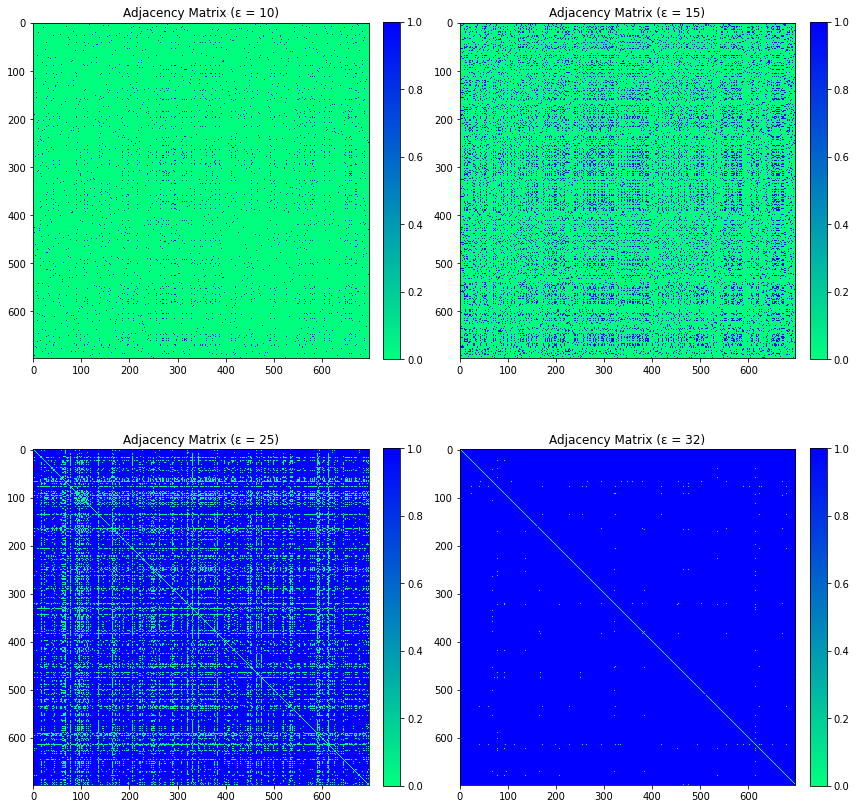

In [4]:
epsilon_values = [10, 15, 25, 32] #based on the ranges from the last code snippet, picked 4 numebrs between the range

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes = axes.flatten()

for i, epsilon in enumerate(epsilon_values):
    # Create the adjacency matrix
    adjacency_matrix = (pairwise_distances < epsilon).astype(float)
    np.fill_diagonal(adjacency_matrix, 0)  # Set diagonal to 0

    # Visualize adjacency matrix
    ax = axes[i]
    im = ax.imshow(adjacency_matrix, cmap='winter_r', interpolation='none')
    ax.set_title(f'Adjacency Matrix (ε = {epsilon})')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

 ## Question 3.2

In [5]:
"""
Sources/Background research:

1) Build weighted graph using nearest neighbors
2)Compute pairwise shortest distance matrix
3) Use centering matrix
4) compute leading eigenvectors and eigenvalues

https://matplotlib.org/stable/gallery/text_labels_and_annotations/demo_annotation_box.html
https://stackoverflow.com/questions/34142485/difference-between-numpy-dot-and-python-3-5-matrix-multiplication
https://stackoverflow.com/questions/74601602/centering-matrix
https://www.geeksforgeeks.org/isomap-for-dimensionality-reduction-in-python/
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html
Dijstktras implementation^
Page 7 of lecture slides - Nonlinear Dimensionality Reduction (Thought process above is basically page 7)
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
https://matplotlib.org/stable/tutorials/pyplot.html(plot code references)
- eigenvalue/eigenvector code was sampled from demo code last module

https://stackoverflow.com/questions/31726643/how-to-plot-in-multiple-subplots

"""


#based on the ranges from the last code snippet, selected a few random epsilon values from the range
epsilon_values = [12, 15, 17, 18, 24, 32] 
shortest_path_matrices = {} #storing for later use
embeddings = {} #to use for visualization
#num of rows
m = pairwise_distances.shape[0] 

for epsilon in epsilon_values:
    adjacency_matrix = np.zeros((m, m)) #empty adjacency matrix for each iteration
    for i in range(m):
        for j in range(m):
            distance = pairwise_distances[i, j]
            if distance <= epsilon:
                #distance as edge weight and no iedge is distance is greater than e
                adjacency_matrix[i, j] = distance  
            else:
                adjacency_matrix[i, j] = 0
                
                
    shortest_path_matrix = shortest_path(adjacency_matrix, directed=False, method='D')
    shortest_path_matrices[epsilon] = shortest_path_matrix
    #print(f"Number of connected components for epsilon={epsilon}: {n_components}")
    #print(f"Shortest path matrix (epsilon={epsilon}):")
    #print(shortest_path_matrix)
    
    # Centering matrix - equation from Page 7 of Nonlienar dimensionality reduction lecture 

    H = np.eye(m) - np.ones((m, m)) / m
    #np eye is identity matrix, np ones creates matrix of size mXm where every element is 1
    #Equation was crafted based on slides 14,15,16 of Nonlienar dimensionality reduction lecture
    #squared_distances = shortest_path_matrix ** 2
    #centered_distances = np.dot(H, squared_distances)
    #K = -0.5 * np.dot(centered_distances, H)
    
    K = -0.5 * np.dot(np.dot(H, (shortest_path_matrix ** 2)), H) 

    # Eigenvalue decomposition - sourced from demo code
    eigvals, eigvecs = np.linalg.eigh(K)
    sorted_indices = np.argsort(eigvals)[::-1]  # Sorting eigenvalues
    top_eigvecs = eigvecs[:, sorted_indices[:2]]  # Top 2 eigenvectors

    
    embedding_2d = top_eigvecs * np.sqrt(eigvals[sorted_indices[:2]])
    
    #storing to dict
    embeddings[epsilon] = embedding_2d
    
#all different epsilons stored below    
embedding_2d_eps_12 = embeddings[12]
embedding_2d_eps_15 = embeddings[15]
embedding_2d_eps_17 = embeddings[17]
embedding_2d_eps_18 = embeddings[18]
embedding_2d_eps_24 = embeddings[24]
embedding_2d_eps_32 = embeddings[32]

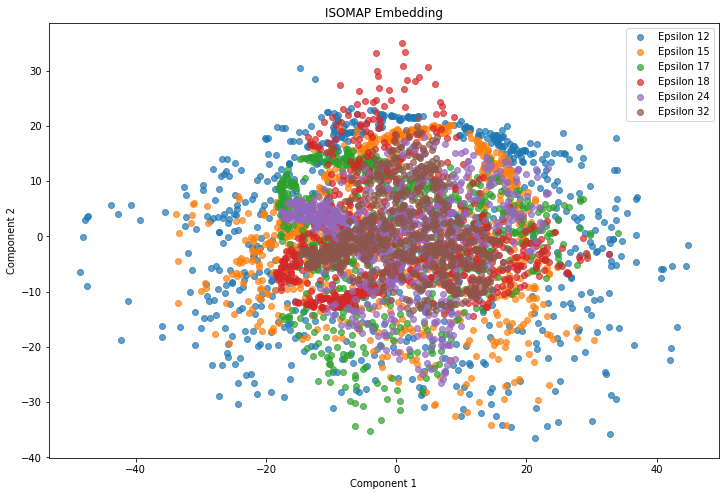

In [6]:
#interesting overlap of each epsilon and how it changes
plt.figure(figsize=(12, 8))

# Loop over  epsilon values
for epsilon in epsilon_values:
    embedding_2d = embeddings[epsilon]  #2D embedding for the current epsilon
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.7, label=f'Epsilon {epsilon}')


plt.title("ISOMAP Embedding")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()  
plt.show()

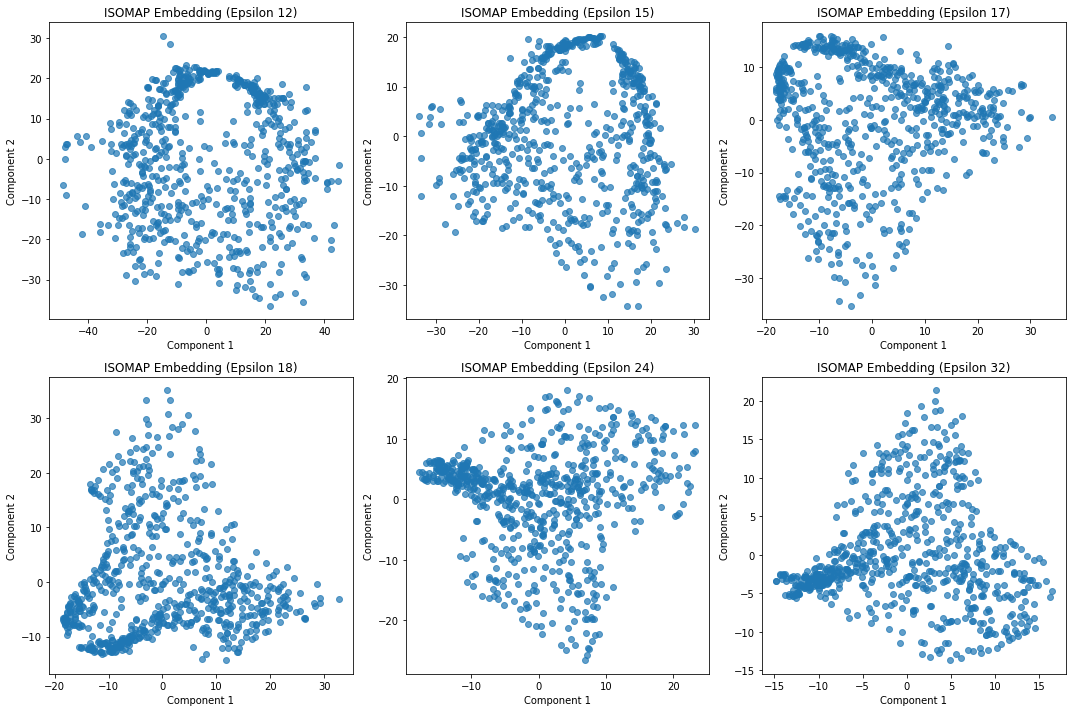

In [7]:
epsilon_values = [12, 15, 17, 18, 24, 32] 

# Create a new figure with multiple subplots (one for each epsilon)
plt.figure(figsize=(15, 10))

# Loop over the epsilon values to create subplots
for i, epsilon in enumerate(epsilon_values, 1):
    embedding_2d = embeddings[epsilon]  # Get the 2D embedding for the current epsilon
    
    
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, and place the current plot in the i-th position
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.7)
    plt.title(f"ISOMAP Embedding (Epsilon {epsilon})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

plt.tight_layout()
plt.show()

In [8]:
print(df.shape)

(698, 4096)


In [9]:
image_size = int(np.sqrt(4096))
print(f"ID: {image_size}x{image_size}")


ID: 64x64


/var/folders/lh/5rvqkkhx7znd__8hcc_6zc_r0000gn/T/ipykernel_30485/3645440030.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


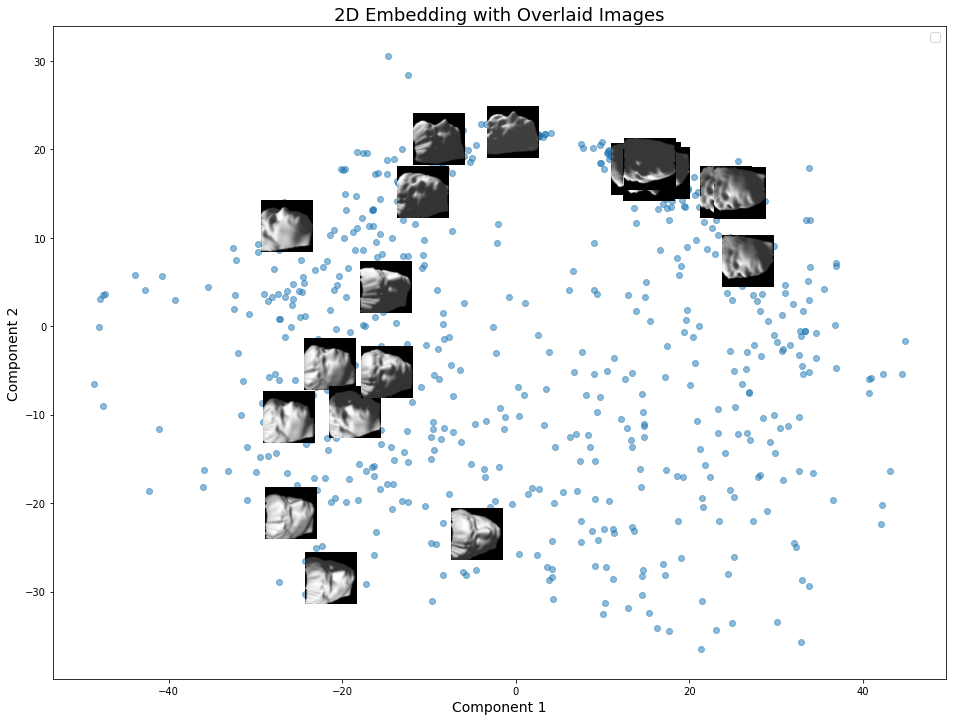

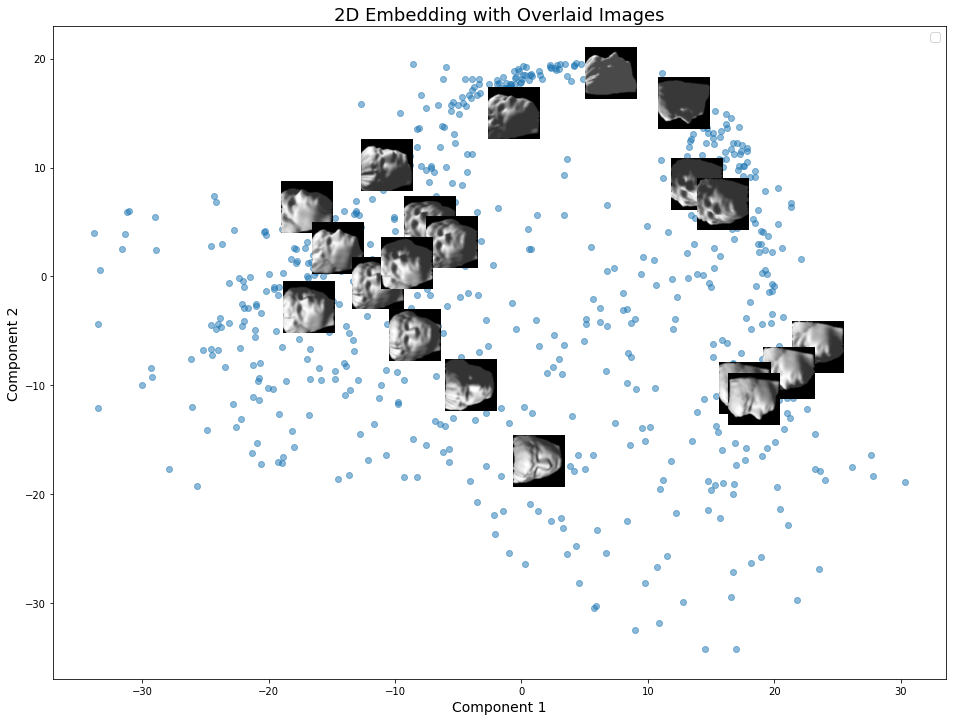

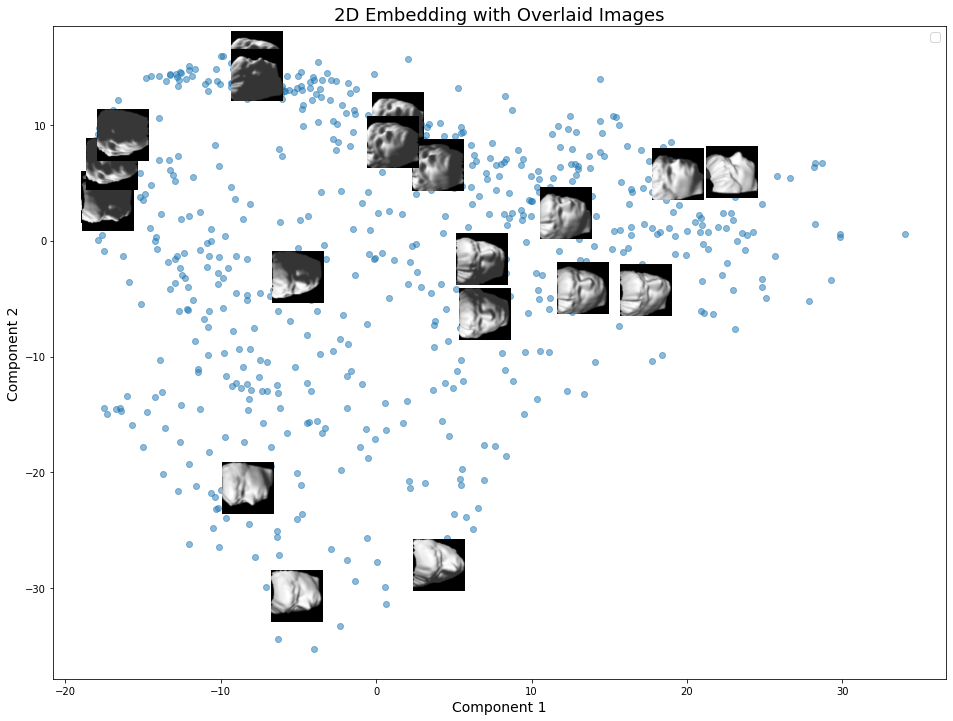

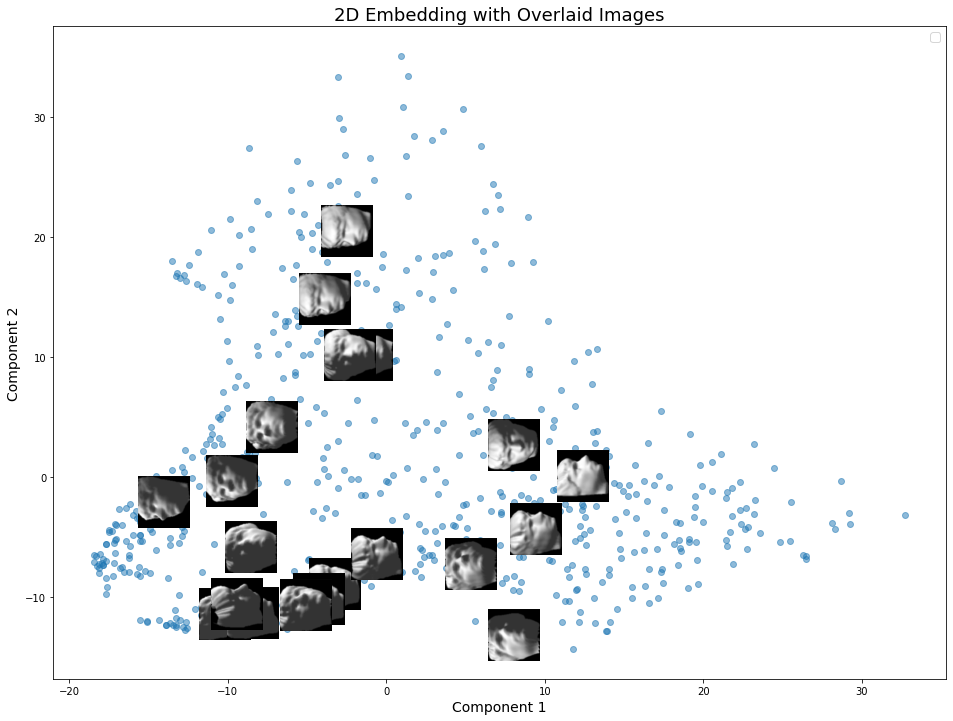

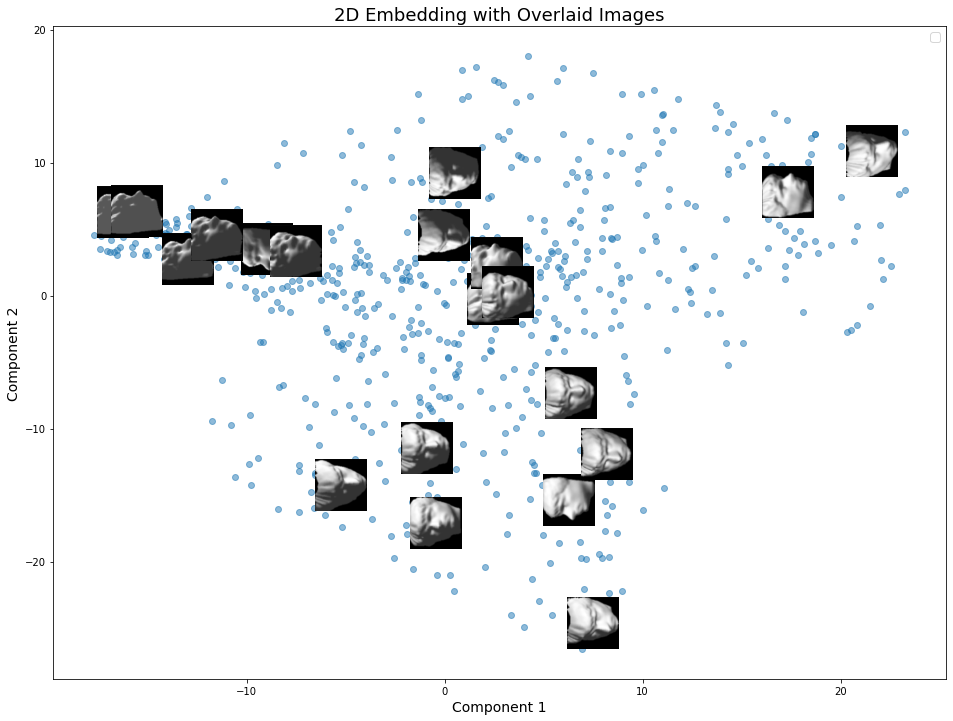

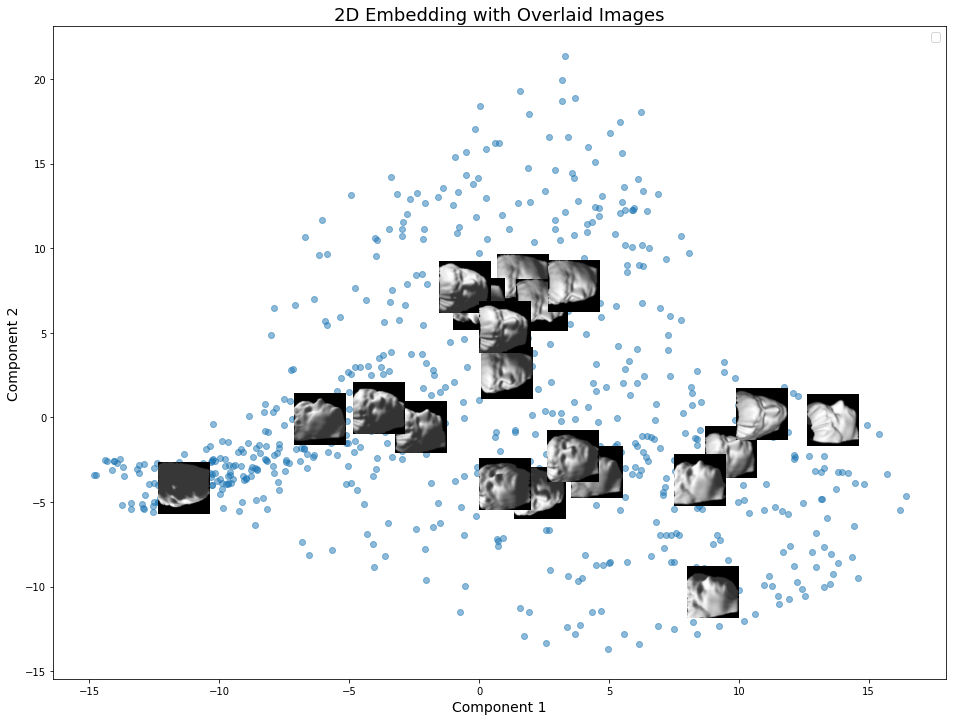

In [10]:
embedding_2d_list = [
    embeddings[12],
    embeddings[15],
    embeddings[17],
    embeddings[18],
    embeddings[24],
    embeddings[32]
]
num_points = 20

#max index was causing issues so made more dynamic
max_index = len(df) - 1

#image shape calculated by squaring image size
image_shape = (64, 64)

#each iteration of loop uses new epsilon value to generate graph with different 2d embedding
for embedding_2d in embedding_2d_list: 
    # random selection 20 indices
    selected_indices = np.random.choice(range(max_index + 1), size=num_points, replace=False)

    plt.figure(figsize=(16, 12)) 

    # Scatter plot of 2D embedding
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.5) 

    # for loop tp Overlay images on the scatter plot
    for i in selected_indices:
        image = df[i].reshape(image_shape) 
        img_box = OffsetImage(image, zoom=0.8, cmap='gray')  
        ab = AnnotationBbox(img_box, (embedding_2d[i, 0], embedding_2d[i, 1]), frameon=False)
        plt.gca().add_artist(ab)
        #for overlay^

    # Labeling
    plt.xlabel('Component 1', fontsize=14)  
    plt.ylabel('Component 2', fontsize=14)
    plt.title('2D Embedding with Overlaid Images', fontsize=18)  
    plt.legend(fontsize=12)  

    plt.show()

## Question 3.3

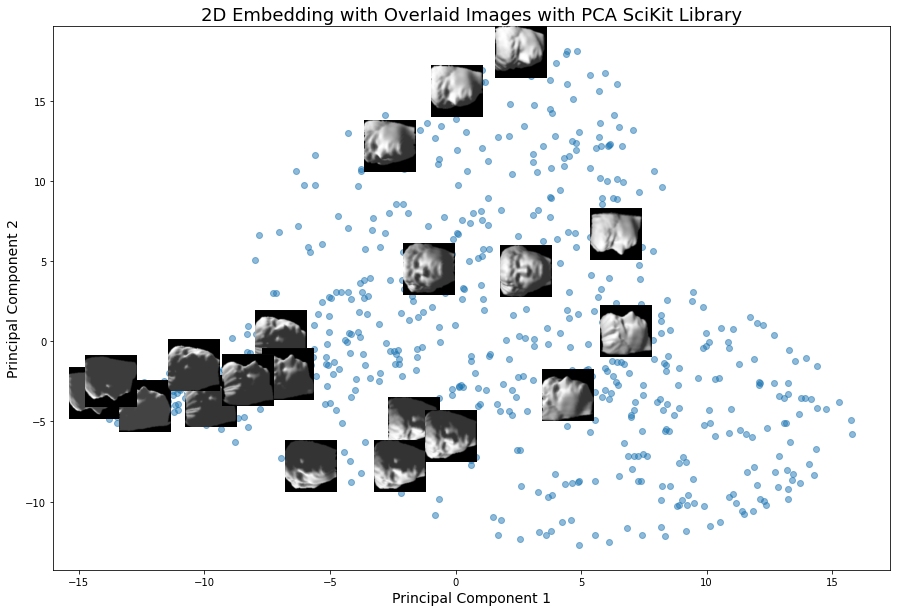

In [11]:
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(df)

# Plot the results
plt.figure(figsize=(15, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("PCA Projection into Top 2 Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")


#Essentially the same code as Question 3.2, slightlt modified to match
num_points = 20  
max_index = len(df) - 1  
selected_indices = np.random.choice(range(max_index + 1), size=num_points, replace=False)

image_shape = (64, 64)

for i in selected_indices:
    image = df[i].reshape(image_shape) 
    img_box = OffsetImage(image, zoom=0.8, cmap='gray')  
    ab = AnnotationBbox(img_box, (pca_result[i, 0], pca_result[i, 1]), frameon=False)
    plt.gca().add_artist(ab)

plt.xlabel('Principal Component 1', fontsize=14)  
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('2D Embedding with Overlaid Images with PCA SciKit Library', fontsize=18)  

plt.show()